In [2]:
from math import cos, sin, asin, acos, gcd, atan2
import numpy as np
from numpy import array, dot, degrees, cross
from numpy.linalg import inv, det, solve, norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csl_generator as csl
import gb_generator as gbc

%matplotlib notebook

## Produce Lists of CSL boundaries for any given rotation axis (hkl) :



In [3]:
axis = np.array([1,2,1])

## list Sigma boundaries < 50
csl.print_list(axis,50)


Sigma:     1  Theta:   0.00 
Sigma:     5  Theta:  101.54 
Sigma:     7  Theta:  135.58 
Sigma:    11  Theta:  62.96 
Sigma:    15  Theta:  78.46 
Sigma:    21  Theta:  44.42 
Sigma:    25  Theta:  156.93 
Sigma:    29  Theta:  149.55 
Sigma:    31  Theta:  52.20 
Sigma:    33  Theta:  117.04 
Sigma:    35  Theta:  34.05 
Sigma:    49  Theta:  88.83 


## Select a sigma and get the characteristics of the GB:

In [4]:
# pick a sigma for this axis, ex: 15.

sigma = 15 

theta, m, n = csl.get_theta_m_n_list(axis,sigma)[0]

R = csl.rot(axis, theta)

M1, M2 = csl.Create_minimal_cell_Method_1(sigma,axis,R)


print('Angle:',degrees(theta),'\n','Sigma:',sigma,'\n', 'Minimal cells:','\n', M1,'\n',M2,'\n', )

Angle: 78.46304096718451 
 Sigma: 15 
 Minimal cells: 
 [[ 3  0  1]
 [ 0 -1  2]
 [ 0  2  1]] 
 [[ 1  2  1]
 [ 2 -1  2]
 [-2  0  1]] 



## Produce Lists of GB planes for the chosen boundary :


In [15]:
# the higher the limit the higher the indices of GB plnaes produced.

lim = 8

V1, V2, M, Gb = csl.Create_Possible_GB_Plane_List(axis, m,n,lim)

df = pd.DataFrame(
    {'GB1': list(V1),
     'GB2': list(V2),
     'Type': Gb
    })

df.head()

,GB1,GB2,Type
0,"[0, 1, -2]","[-2, 1, 0]",Tilt
1,"[3, 0, 0]","[1, 2, -2]",Mixed
2,"[0, -1, 2]","[2, -1, 0]",Tilt
3,"[-3, 0, 0]","[-1, -2, 2]",Mixed
4,"[-1, -2, -1]","[-1, -2, -1]",Twist


## Criteria for finding the GB plane of ineterest: 
###  1- Based on the type of GB plane: 

In [10]:
## Gb types: Symmetric Tilt, Tilt, Twist, Mixed

df[df['Type'] == 'Mixed'].head()

,GB1,GB2,Type
3,"[-3, 0, 0]","[-1, -2, 2]",Mixed
5,"[3, 0, 0]","[1, 2, -2]",Mixed
6,"[2, -2, -1]","[0, 0, -3]",Mixed
7,"[4, 2, 1]","[2, 4, -1]",Mixed
8,"[-1, -3, 1]","[1, -3, -1]",Mixed



### 2 - Based on the minimum number of atoms in an orthogonal cell:
####  _This can be of interest for DFT calculations that require smaller cells:_


In [16]:
basis = 'fcc'
Number = np.zeros(len(V1))
for i in range((len(V1))):
    Number[i] = csl.Find_Orthogonal_cell(basis,axis,m,n,V1[i])[2]

In [17]:
df['Number'] = list(Number)    

df[df['Number'] < 300]

,GB1,GB2,Type,Number
4,"[-1, -2, -1]","[-1, -2, -1]",Twist,60.0
5,"[1, 2, 1]","[1, 2, 1]",Twist,60.0
29,"[5, -2, -1]","[1, 2, -5]",Symmetric Tilt,60.0
44,"[-5, 2, 1]","[-1, -2, 5]",Symmetric Tilt,60.0


### 3- Based on proximity to a particular boundary, for example the Symmetric tilts:
####  _This is how I created various steps on grain boundaries with vicinal orientations in the following work:_
#### __(https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.043601)__

In [18]:
SymmTiltGbs = []
for i in range(len(V1)):
    if str(Gb[i]) == 'Symmetric Tilt':
        SymmTiltGbs.append(V1[i])

# Find GBs less than 5 degrees from any of the symmetric tilt boundaries in this system

Delta = 5
Min_angles = []
for i in range(len(V1)):
    angles = []
    for j in range(len(SymmTiltGbs)):
        angles.append(csl.angv(V1[i],SymmTiltGbs[j]))
    Min_angles.append(min(angles))    


In [19]:
df['Angles'] = Min_angles

df[df['Angles'] < Delta]

,GB1,GB2,Type,Number,Angles
29,"[5, -2, -1]","[1, 2, -5]",Symmetric Tilt,60.0,0.000000
44,"[-5, 2, 1]","[-1, -2, 5]",Symmetric Tilt,60.0,0.000000
1497,"[18, -6, -3]","[4, 8, -17]",Mixed,14760.0,3.655525
1509,"[-18, 6, 3]","[-4, -8, 17]",Mixed,14760.0,3.655525
1794,"[-17, 8, 4]","[-3, -6, 18]",Mixed,14760.0,3.655525
1845,"[17, -8, -4]","[3, 6, -18]",Mixed,14760.0,3.655525


## Select a GB plane and go on:
### You only need to pick the GB1 plane

In [23]:
GB_plane = [-17, 8, 4]
LatP = 4

In [24]:
# instantiate a GB:
my_gb = gbc.GB_character()

# give all the characteristics
my_gb.ParseGB (axis,basis,LatP,m,n,GB_plane)

# Create the bicrystal
my_gb.CSL_Bicrystal_Atom_generator()

# remove atoms closer than this fraction of the latice parameter
my_gb.overD = 0.4

# cell dimension [x,y,z], with x along GB normal and y and z in the GB plane

dim = [1,1,1]

# put the rigib body translation to False: it shows the as constructed GB after atom removal, put it to True: 
# you will produce multiple initial structures.

my_gb.WriteGB(my_gb.overD,'g1', False, dim[0], dim[1], dim[2])

<<------ 20 atoms are being removed! ------>>


In [25]:
## extract atom positions of the two grains:

X = my_gb.atoms1
Y = my_gb.atoms2

In [26]:
# 3d plot of the gb, that can be shown in any cartesian view direction:

def plot_gb(X,Y, view_dir = [0,1,0]):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0],X[:,1],X[:,2],'o', s = 20, facecolor = 'y',edgecolor='none', alpha=0.2 )
    ax.scatter(Y[:,0],Y[:,1],Y[:,2],'o',s = 20,facecolor = 'b',edgecolor='none', alpha=0.2)
    ax.scatter(0,0,0,'s',s = 200,facecolor = 'r',edgecolor='none')
    ax.set_proj_type('ortho')
    ax.grid(False)
    az = degrees(atan2(view_dir[1],view_dir[0]))
    el = degrees(asin(view_dir[2]/norm(view_dir)))
    ax.view_init(azim = az, elev = el)       
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    return            


<IPython.core.display.Javascript object>


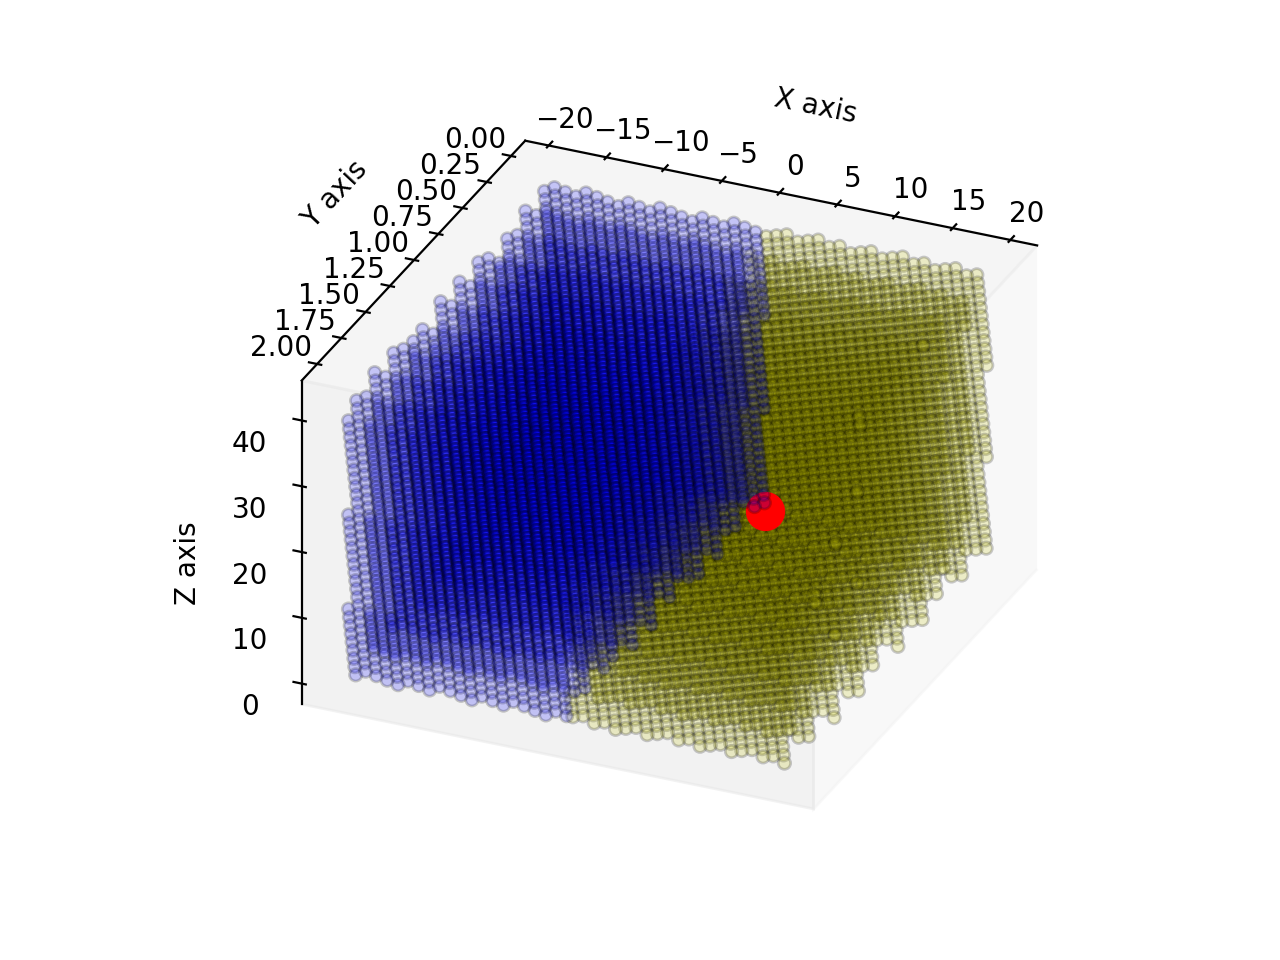

In [27]:
plot_gb(X,Y,[0,1,0])